In [10]:
# 0_confirm_env.py — run to verify versions
import sys, xgboost, sklearn, pandas, numpy
print("python:", sys.version.splitlines()[0])
print("xgboost:", xgboost.__version__)   # you reported 3.1.2
print("sklearn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)


python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
xgboost: 3.1.1
sklearn: 1.6.1
pandas: 2.2.3
numpy: 2.1.3


In [11]:
# 1_imports.py
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, brier_score_loss
)

import xgboost as xgb
sns.set(style="whitegrid")


In [12]:
df = pd.read_csv("C:\\Users\\calpo\\Downloads\\ML_Diabetes\\diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


In [13]:
# 3_eda.py
print("Columns:", df.columns.tolist())
print("Nulls per column:\n", df.isna().sum())
orig_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Dropped duplicates: {orig_rows - df.shape[0]} rows. Now: {df.shape}")
print("Class distribution (3-class):\n", df['Diabetes_012'].value_counts())


Columns: ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Nulls per column:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Dropped duplicates: 23899 rows. Now: (229781, 22)
Class distribution (3-class):
 Diabetes_012
0    190055
2   

In [14]:
# 4_features.py
TARGET = "Diabetes_012"
FEATURES = [c for c in df.columns if c != TARGET]
X = df[FEATURES].copy()
y_3c = df[TARGET].astype(int).copy()   # 0,1,2
# show feature example
X.head()


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [15]:
# 5_binary_map.py
y_bin = (y_3c > 0).astype(int)   # 0 = Healthy, 1 = At-Risk (PreDM + DM)
print("Binary class counts:\n", pd.Series(y_bin).value_counts())


Binary class counts:
 Diabetes_012
0    190055
1     39726
Name: count, dtype: int64


In [16]:
# 6_split.py
RANDOM_SEED = 42
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_bin, test_size=0.30, random_state=RANDOM_SEED, stratify=y_bin
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
)
print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Train/Val/Test sizes: 160846 34467 34468


In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---- 0. Load or train 3-class model ----
# Check if bst3 exists, if not try to load from file or train it
if 'bst3' not in globals():
    try:
        import os
        if os.path.exists("models/3class_bst.json"):
            bst3 = xgb.Booster()
            bst3.load_model("models/3class_bst.json")
            print("Loaded 3-class model from file")
        else:
            print("Model file not found. Training 3-class model now...")
            # Train the model if it doesn't exist
            y_train_3c = (y_3c.loc[X_train.index]).astype(int)
            y_val_3c = (y_3c.loc[X_val.index]).astype(int)
            dtrain3 = xgb.DMatrix(X_train, label=y_train_3c)
            dval3 = xgb.DMatrix(X_val, label=y_val_3c)
            
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(y_train_3c)
            cw = compute_class_weight('balanced', classes=classes, y=y_train_3c)
            class_weight_dict = {c:w for c,w in zip(classes, cw)}
            sample_weight = np.array([class_weight_dict[y] for y in y_train_3c])
            
            params3 = {"objective":"multi:softprob", "num_class":3, "learning_rate":0.05, "max_depth":5, "eval_metric":"mlogloss"}
            dtrain3w = xgb.DMatrix(X_train, label=y_train_3c, weight=sample_weight)
            bst3 = xgb.train(params3, dtrain3w, num_boost_round=300, evals=[(dval3,'val')], early_stopping_rounds=50, verbose_eval=False)
            bst3.save_model("models/3class_bst.json")
            print("3-class model trained and saved")
    except Exception as e:
        print(f"Error loading/training 3-class model: {e}")
        print("Skipping 3-class evaluation")
        bst3 = None

# Get 3-class labels for test set (y_test is binary, we need y_3c)
y_test_3c = y_3c.loc[X_test.index].astype(int)

if bst3 is not None:
    # ---- 1. Predict Using 3-Class XGBoost Model ----
    dtest_3 = xgb.DMatrix(X_test)
    y_proba_3 = bst3.predict(dtest_3)       # shape: (n_samples, 3)
    y_pred_3 = np.argmax(y_proba_3, axis=1)       # class with highest probability

    # ---- 2. Compute Confusion Matrices ----
    cm_3 = confusion_matrix(y_test_3c, y_pred_3)

    # Row-normalized (%)
    cm_3_norm = cm_3.astype('float') / cm_3.sum(axis=1)[:, None]
    cm_3_norm = np.nan_to_num(cm_3_norm) * 100

    labels_3 = ["Healthy", "Pre-Diabetic", "Diabetic"]

    # ---- 3. Print Classification Report ----
    print("=== 3-Class Model Classification Report ===")
    print(classification_report(
        y_test_3c, y_pred_3,
        target_names=labels_3,
        digits=4
    ))

    # ---- 4. Plot: Raw Confusion Matrix ----
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_3,
        annot=True,
        fmt="d",
        cmap="Purples",
        xticklabels=labels_3,
        yticklabels=labels_3
    )
    plt.title("3-Class XGBoost Confusion Matrix (Counts)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ---- 5. Plot: Normalized Confusion Matrix ----
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_3_norm,
        annot=True,
        fmt=".1f",
        cmap="Greens",
        xticklabels=labels_3,
        yticklabels=labels_3
    )
    plt.title("3-Class XGBoost Confusion Matrix (Row-Normalized %)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
else:
    print("Skipping 3-class model evaluation")

XGBoostError: [00:20:56] C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:814: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?

In [19]:
# Create models directory if it doesn't exist
import os
os.makedirs("models", exist_ok=True)
print("Models folder ready:", os.listdir())


Models folder ready: ['.conda', '.venv', '.vscode', 'analysis.py', 'cleaned_health_data.csv', 'COMPLETE_GUIDE.md', 'data.ipynb', 'Diabetes.ipynb', 'diabetes_012_health_indicators_BRFSS2015.csv', 'diabetes_risk_app', 'diabetes_risk_binary_model.json', 'FIX_NUMPY_IMPORT.md', 'INSTALL_INSTRUCTIONS.md', 'lr_feature_importance.png', 'lr_roc_curve.png', 'models', 'output.txt', 'project', 'PROJECT_SUMMARY.md', 'QUICK_REFERENCE.txt', 'requirements.txt', 'scripts', 'SETUP_GUIDE.md', 'streamlit_app.log', 'streamlit_app_restart.log', 'streamlit_clean.log', 'streamlit_final.log', 'Sugar ML1_project.ipynb', 'test.ipynb', 'training_full.log', 'tuning_extended.log', 'tuning_full.log', 'tuning_full_30.log', 'uv']


In [20]:
# 7_scaler.py
# Identify continuous columns (example: BMI, PhysHlth, MentHlth)
continuous = ['BMI','PhysHlth','MentHlth']  # adjust if different
scaler = StandardScaler()
X_train[continuous] = scaler.fit_transform(X_train[continuous])
X_val[continuous] = scaler.transform(X_val[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])
# Save scaler
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']

In [21]:
# 8_scale_weight.py
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = float(neg) / float(pos)
print("scale_pos_weight:", scale_pos_weight)


scale_pos_weight: 4.784162830840046


In [22]:
# 9_train_xgb.py
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=5,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    eval_metric='auc',
    early_stopping_rounds=50  # Moved to constructor for XGBoost 3.x
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# quick val AUC
val_proba = xgb_model.predict_proba(X_val)[:,1]
print("Val AUC:", roc_auc_score(y_val, val_proba))


Val AUC: 0.8152198346010303


In [23]:
# 10_calibrate.py
calibrator = CalibratedClassifierCV(xgb_model, method='isotonic', cv='prefit')
calibrator.fit(X_val, y_val)
final_model = calibrator   # use final_model.predict_proba(...)
# Save final_model
joblib.dump(final_model, "models/diabetes_final_model.pkl")


c:\Users\calpo\anaconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


['models/diabetes_final_model.pkl']

In [24]:
# 11_logistic_baseline.py
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
joblib.dump(lr, "models/logistic_baseline.pkl")
print("LR Val AUC:", roc_auc_score(y_val, lr.predict_proba(X_val)[:,1]))


LR Val AUC: 0.8049332527945214


In [25]:
# 12_3class_train.py
# Use original 3-class labels and sample weights (no SMOTE)
y_train_3c = (y_3c.loc[X_train.index]).astype(int)
y_val_3c = (y_3c.loc[X_val.index]).astype(int)
dtrain3 = xgb.DMatrix(X_train, label=y_train_3c)
dval3 = xgb.DMatrix(X_val, label=y_val_3c)

# compute class weights for multi-class as per-class inverse freq
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_3c)
cw = compute_class_weight('balanced', classes=classes, y=y_train_3c)
class_weight_dict = {c:w for c,w in zip(classes, cw)}
sample_weight = np.array([class_weight_dict[y] for y in y_train_3c])

params3 = {"objective":"multi:softprob", "num_class":3, "learning_rate":0.05, "max_depth":5, "eval_metric":"mlogloss"}
dtrain3w = xgb.DMatrix(X_train, label=y_train_3c, weight=sample_weight)
bst3 = xgb.train(params3, dtrain3w, num_boost_round=300, evals=[(dval3,'val')], early_stopping_rounds=50)
# Save
bst3.save_model("models/3class_bst.json")


[0]	val-mlogloss:1.08538
[1]	val-mlogloss:1.07308
[1]	val-mlogloss:1.07308
[2]	val-mlogloss:1.06170
[3]	val-mlogloss:1.05111
[2]	val-mlogloss:1.06170
[3]	val-mlogloss:1.05111
[4]	val-mlogloss:1.04121
[4]	val-mlogloss:1.04121
[5]	val-mlogloss:1.03191
[6]	val-mlogloss:1.02329
[5]	val-mlogloss:1.03191
[6]	val-mlogloss:1.02329
[7]	val-mlogloss:1.01524
[8]	val-mlogloss:1.00772
[7]	val-mlogloss:1.01524
[8]	val-mlogloss:1.00772
[9]	val-mlogloss:1.00062
[10]	val-mlogloss:0.99402
[9]	val-mlogloss:1.00062
[10]	val-mlogloss:0.99402
[11]	val-mlogloss:0.98786
[12]	val-mlogloss:0.98207
[11]	val-mlogloss:0.98786
[12]	val-mlogloss:0.98207
[13]	val-mlogloss:0.97655
[13]	val-mlogloss:0.97655
[14]	val-mlogloss:0.97148
[15]	val-mlogloss:0.96665
[14]	val-mlogloss:0.97148
[15]	val-mlogloss:0.96665
[16]	val-mlogloss:0.96218
[16]	val-mlogloss:0.96218
[17]	val-mlogloss:0.95789
[18]	val-mlogloss:0.95388
[17]	val-mlogloss:0.95789
[18]	val-mlogloss:0.95388
[19]	val-mlogloss:0.95019
[20]	val-mlogloss:0.94664
[21]	

In [26]:
# 13_evaluate.py
def eval_binary(model, X, y_true, threshold=0.30):
    proba = model.predict_proba(X)[:,1]
    pred = (proba >= threshold).astype(int)
    print("Threshold:", threshold)
    print("ROC AUC:", roc_auc_score(y_true, proba))
    print("Brier:", brier_score_loss(y_true, proba))
    print(classification_report(y_true, pred, digits=4))
    print("Confusion:\n", confusion_matrix(y_true, pred))
    return proba, pred

print("=== XGBoost (calibrated) on TEST ===")
xgb_proba, xgb_pred = eval_binary(final_model, X_test, y_test, threshold=0.30)

print("\n=== Logistic Regression baseline on TEST ===")
lr_proba, lr_pred = eval_binary(lr, X_test, y_test, threshold=0.30)

# 3-class evaluation (if bst3 exists)
pred3 = None  # Initialize pred3 as None
try:
    if 'bst3' in globals() and bst3 is not None:
        dtest3 = xgb.DMatrix(X_test)
        proba3 = bst3.predict(dtest3)
        pred3 = np.argmax(proba3, axis=1)
        print("\n=== 3-Class model evaluation (test) ===")
        print(classification_report(y_3c.loc[X_test.index], pred3, digits=4))
    else:
        print("\n3-class model not available — skip")
except Exception as e:
    print(f"\n3-class model evaluation failed: {e}")
    pred3 = None

=== XGBoost (calibrated) on TEST ===
Threshold: 0.3
Threshold: 0.3
ROC AUC: 0.8117026822082506
Brier: 0.11485847918633904
              precision    recall  f1-score   support

           0     0.9058    0.8344    0.8687     28509
           1     0.4247    0.5848    0.4921      5959

    accuracy                         0.7913     34468
   macro avg     0.6653    0.7096    0.6804     34468
weighted avg     0.8226    0.7913    0.8036     34468

Confusion:
 [[23789  4720]
 [ 2474  3485]]

=== Logistic Regression baseline on TEST ===
Threshold: 0.3
ROC AUC: 0.8042222217787853
Brier: 0.18256504986805727
              precision    recall  f1-score   support

           0     0.9659    0.4828    0.6438     28509
           1     0.2707    0.9184    0.4182      5959

    accuracy                         0.5581     34468
   macro avg     0.6183    0.7006    0.5310     34468
weighted avg     0.8457    0.5581    0.6048     34468

Confusion:
 [[13764 14745]
 [  486  5473]]
ROC AUC: 0.81170268220

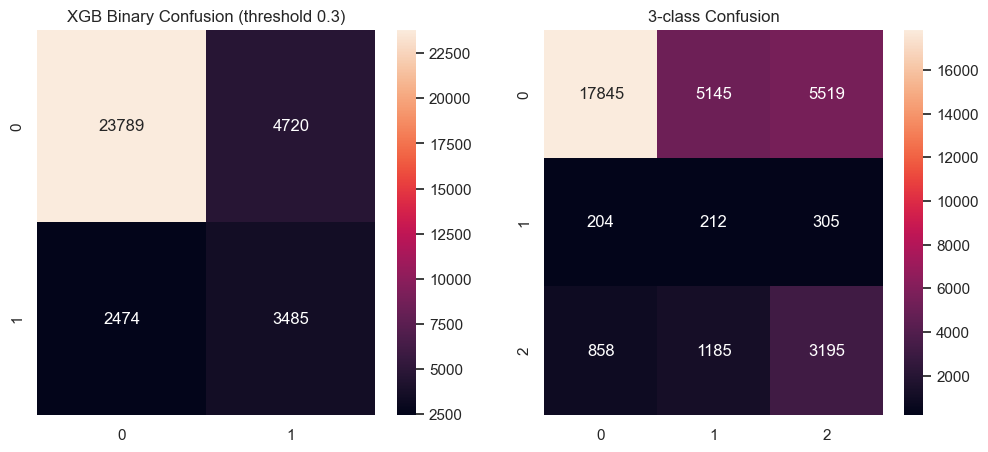

In [ ]:
# 14a_confusion.py
import seaborn as sns

# Check if required variables exist
if 'y_test' not in globals() or 'xgb_pred' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', ax=axes[0])
    axes[0].set_title("XGB Binary Confusion (threshold 0.3)")
    try:
        if 'pred3' in globals() and pred3 is not None:
            sns.heatmap(confusion_matrix(y_3c.loc[X_test.index], pred3), annot=True, fmt='d', ax=axes[1])
            axes[1].set_title("3-class Confusion")
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, "3-class model not available", ha='center', va='center')
    except Exception as e:
        print(f"Error plotting 3-class confusion: {e}")
        axes[1].axis('off')
    plt.show()

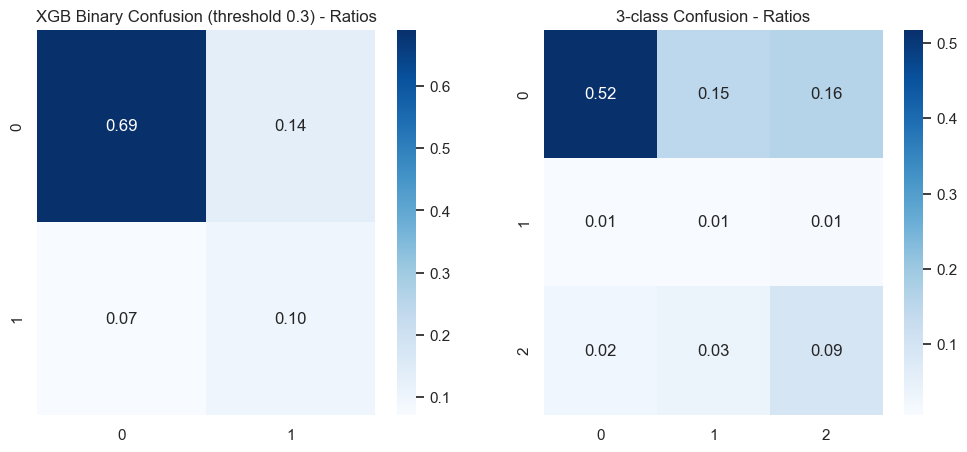

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Check if required variables exist
if 'y_test' not in globals() or 'xgb_pred' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Binary confusion matrix normalized ---
    cm_binary = confusion_matrix(y_test, xgb_pred)
    cm_binary_ratio = cm_binary.astype('float') / cm_binary.sum()   # global ratio

    sns.heatmap(cm_binary_ratio, annot=True, fmt=".2f", ax=axes[0], cmap="Blues")
    axes[0].set_title("XGB Binary Confusion (threshold 0.3) - Ratios")

    # --- 3-class confusion matrix normalized ---
    try:
        if 'pred3' in globals() and pred3 is not None:
            cm_3c = confusion_matrix(y_3c.loc[X_test.index], pred3)
            cm_3c_ratio = cm_3c.astype('float') / cm_3c.sum()
            sns.heatmap(cm_3c_ratio, annot=True, fmt=".2f", ax=axes[1], cmap="Blues")
            axes[1].set_title("3-class Confusion - Ratios")
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, "3-class model not available", ha='center', va='center')
    except Exception as e:
        print(f"Error: {e}")
        axes[1].axis('off')

    plt.show()

In [ ]:
# 14b_roc.py
from sklearn.metrics import roc_curve, auc

# Check if required variables exist
if 'y_test' not in globals() or 'xgb_proba' not in globals() or 'lr_proba' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    fpr_x, tpr_x, _ = roc_curve(y_test, xgb_proba)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_x, tpr_x, label=f"XGB (AUC={roc_auc_score(y_test,xgb_proba):.3f})")
    plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y_test,lr_proba):.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC Curve")
    plt.show()

NameError: name 'y_test' is not defined

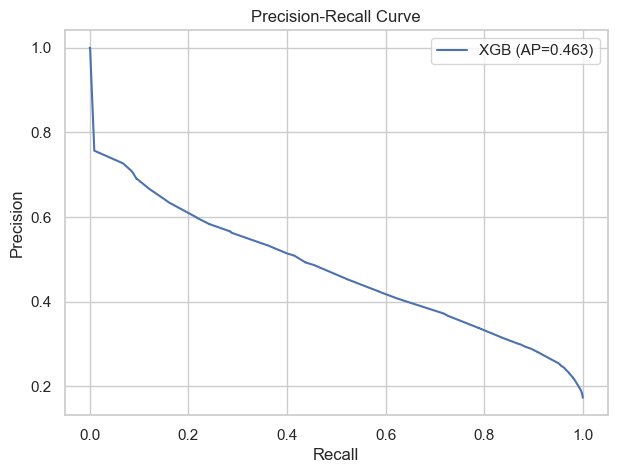

In [ ]:
# 14c_pr.py
from sklearn.metrics import precision_recall_curve, average_precision_score

# Check if required variables exist
if 'y_test' not in globals() or 'xgb_proba' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    prec_x, rec_x, _ = precision_recall_curve(y_test, xgb_proba)
    ap = average_precision_score(y_test, xgb_proba)
    plt.figure(figsize=(7,5))
    plt.plot(rec_x, prec_x, label=f"XGB (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
    plt.legend(); plt.show()

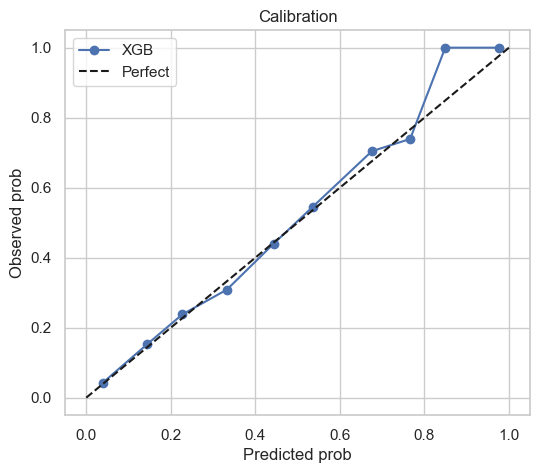

In [ ]:
# 14d_calibration.py

# Check if required variables exist
if 'y_test' not in globals() or 'xgb_proba' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    prob_true, prob_pred = calibration_curve(y_test, xgb_proba, n_bins=10)
    plt.figure(figsize=(6,5))
    plt.plot(prob_pred, prob_true, marker='o', label='XGB')
    plt.plot([0,1],[0,1],'k--', label='Perfect')
    plt.xlabel("Predicted prob"); plt.ylabel("Observed prob"); plt.title("Calibration")
    plt.legend(); plt.show()

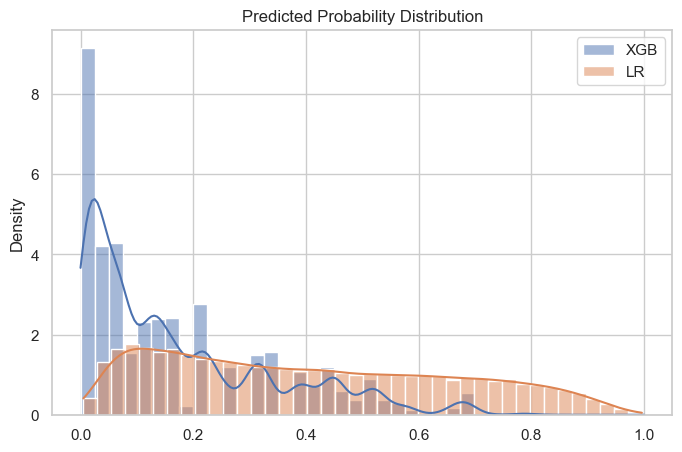

In [ ]:
# 14e_probahist.py

# Check if required variables exist
if 'xgb_proba' not in globals() or 'lr_proba' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    plt.figure(figsize=(8,5))
    sns.histplot(xgb_proba, kde=True, stat="density", label="XGB", bins=40)
    sns.histplot(lr_proba, kde=True, stat="density", label="LR", bins=40, alpha=0.5)
    plt.legend(); plt.title("Predicted Probability Distribution"); plt.show()

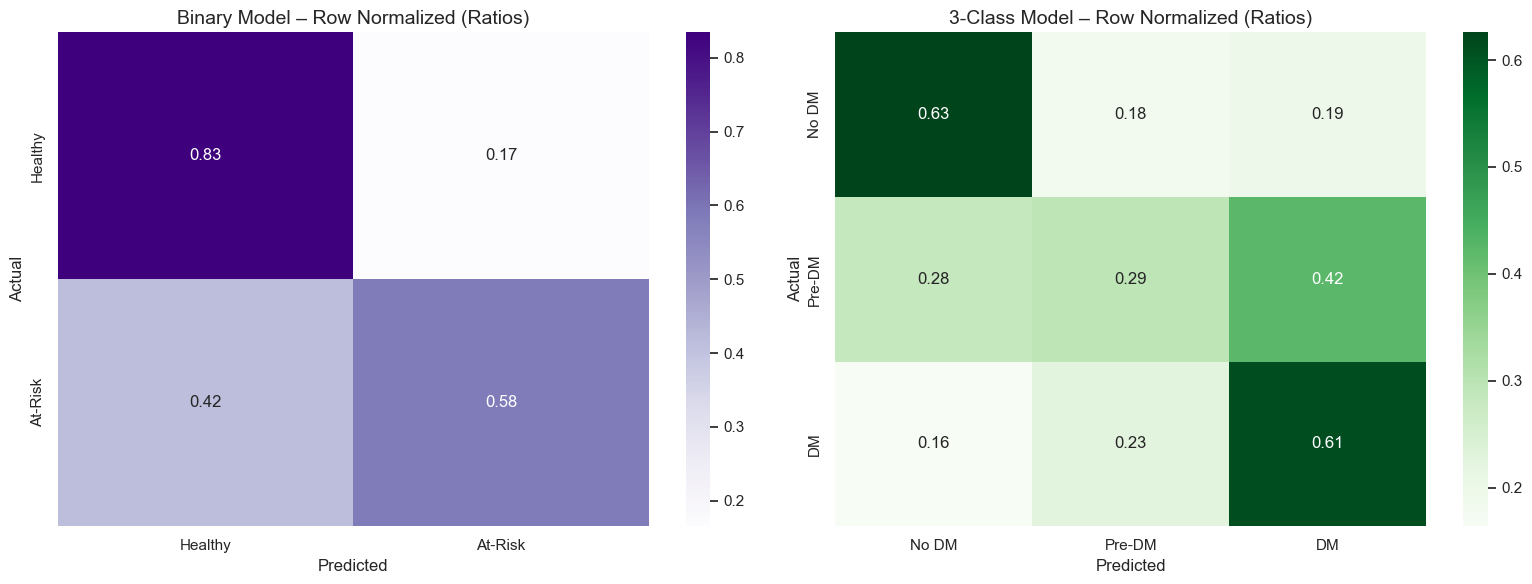

In [ ]:
# Binary CM normalized (ratios)
# Check if required variables exist
if 'y_test' not in globals() or 'xgb_pred' not in globals():
    print("ERROR: Required variables not defined. Please run cells 1-13 first in order.")
else:
    cm_bin = confusion_matrix(y_test, xgb_pred)
    cm_bin_norm = cm_bin.astype('float') / cm_bin.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Binary normalized heatmap
    sns.heatmap(
        cm_bin_norm,
        annot=True, fmt=".2f", cmap="Purples",
        xticklabels=["Healthy", "At-Risk"],
        yticklabels=["Healthy", "At-Risk"],
        ax=axes[0]
    )
    axes[0].set_title("Binary Model – Row Normalized (Ratios)", fontsize=14)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

    # 3-Class CM normalized (ratios)
    try:
        if 'pred3' in globals() and pred3 is not None:
            cm_3 = confusion_matrix(y_3c.loc[X_test.index], pred3)
            cm_3_norm = cm_3.astype('float') / cm_3.sum(axis=1)[:, np.newaxis]
            sns.heatmap(
                cm_3_norm,
                annot=True, fmt=".2f", cmap="Greens",
                xticklabels=["No DM", "Pre-DM", "DM"],
                yticklabels=["No DM", "Pre-DM", "DM"],
                ax=axes[1]
            )
            axes[1].set_title("3-Class Model – Row Normalized (Ratios)", fontsize=14)
            axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, "3-class model not available", ha='center', va='center')
    except Exception as e:
        print(f"Error: {e}")
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

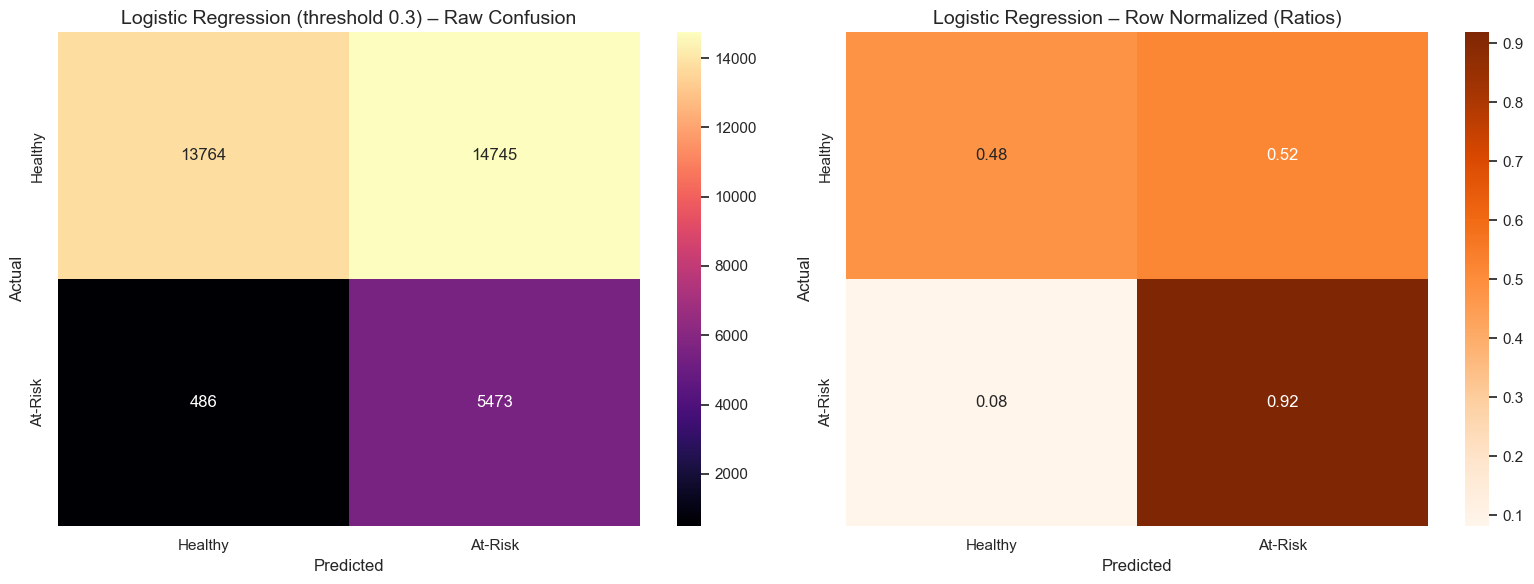

In [ ]:
# =============================
# LOGISTIC REGRESSION CONFUSION MATRICES (Ratios)
# =============================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix (raw counts)
cm_lr = confusion_matrix(y_test, lr_pred)

# Row-normalized version (ratios)
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_lr_norm = np.nan_to_num(cm_lr_norm)

labels_bin = ["Healthy", "At-Risk"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -------------------------------
# Raw Confusion Matrix
# -------------------------------
sns.heatmap(
    cm_lr, annot=True, fmt="d", cmap="magma",
    xticklabels=labels_bin, yticklabels=labels_bin,
    ax=axes[0]
)
axes[0].set_title("Logistic Regression (threshold 0.3) – Raw Confusion", fontsize=14)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# -------------------------------
# Row-Normalized Confusion Matrix (Ratios)
# -------------------------------
sns.heatmap(
    cm_lr_norm, annot=True, fmt=".2f", cmap="Oranges",
    xticklabels=labels_bin, yticklabels=labels_bin,
    ax=axes[1]
)
axes[1].set_title("Logistic Regression – Row Normalized (Ratios)", fontsize=14)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
lr_model = LogisticRegression(
    solver='liblinear',        # good for small datasets / binary classification
    random_state=RANDOM_SEED
)

# Fit the model
lr_model.fit(X_train, y_train)

# Now you can predict probabilities
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Apply threshold
threshold = 0.3
lr_pred = (lr_pred_proba >= threshold).astype(int)

In [ ]:
print("=== Logistic Regression baseline on TEST ===")

from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss

# Probability prediction
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Apply threshold
threshold = 0.3
lr_pred = (lr_pred_proba >= threshold).astype(int)

# Metrics
auc_lr = roc_auc_score(y_test, lr_pred_proba)
brier_lr = brier_score_loss(y_test, lr_pred_proba)

print(f"Threshold: {threshold}")
print(f"ROC AUC: {auc_lr}")
print(f"Brier: {brier_lr}")
print(classification_report(y_test, lr_pred))

# Confusion matrix (raw)
cm_lr = confusion_matrix(y_test, lr_pred)
print("\nConfusion:\n", cm_lr)


=== Logistic Regression baseline on TEST ===
Threshold: 0.3
ROC AUC: 0.8038443370302961
Brier: 0.11740650929548556
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     28509
           1       0.45      0.49      0.47      5959

    accuracy                           0.81     34468
   macro avg       0.67      0.68      0.68     34468
weighted avg       0.81      0.81      0.81     34468


Confusion:
 [[24907  3602]
 [ 3036  2923]]
